In [2]:
import torch
import spacy
import json
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from summarizer import Summarizer
from rouge_score import rouge_scorer
from transformers import BartTokenizer

In [4]:
nlp = spacy.load("en_core_web_sm")
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
BERT_summarize = Summarizer()

In [92]:
df = pd.read_csv('dat/cnn_dailymail_test.csv')

In [105]:
def count_token(text):
    return len(tokenizer.encode(text, return_tensors="pt", add_special_tokens=True)[0])
def count_sents(text):
    return len(list(nlp(text).sents))

In [86]:
def split_text_with_spacy(text, max_num_sents=4):
    sents = list(nlp(text).sents)
    chunks = []
    for i in range(0, len(sents), max_num_sents):
        chunks.append(' '.join([str(sent) for sent in sents[i:i+max_num_sents]]))
    return chunks

In [121]:
def merge_summaries(summaries, max_num_sents=2):
    merged_chunks = []
    current_chunk = ""
    for summary in summaries:
        if count_sents(current_chunk+' '+summary) > max_num_sents:
            merged_chunks.append(current_chunk.strip())
            current_chunk = summary
        else:
            current_chunk += " " + summary
    if current_chunk:
        merged_chunks.append(current_chunk.strip())
    return merged_chunks

In [197]:
def bert_summarize_article_with_log(
        article,
        max_bert_input_length=4, # sentences
        step_summary_length=2, # sentences
        final_summary_length=2, # sentences
        log=False
    ):
    article_parts = split_text_with_spacy(article, max_num_sents=max_bert_input_length)
    num_previous_part = len(article_parts)
    round=1
    while len(article_parts) > 1: 
        if log:
            print(f"\noriginal layer-{round:<2}({len(article_parts):<2} parts): {' '*round*3}|", end='')
            for idx, article_part in enumerate(article_parts): print(f"{count_sents(article_part):>2} |", end='')
            print(f"\n summary layer-{round:<2}({len(article_parts):<2} parts): {' '*round*3}|", end='')
        # ---
        summaries = [] 
        for idx, article_part in enumerate(article_parts):
            summary = BERT_summarize(article_part, num_sentences=step_summary_length)
            summaries.append(summary)
            # ---
            if log: print(f"{count_sents(summary):>2} |", end='')
        article_parts = merge_summaries(summaries, max_num_sents=max_bert_input_length)
        num_current_part = len(article_parts)
        if(num_previous_part==num_current_part):
            break
        num_previous_part = num_current_part
        round+=1
    # ---
    if log: print(f"\noriginal layer-{round:<3}({1:<2} parts): {' '*round*3}|{count_sents(article_parts[0]):>2} |", end='')
    # ---
    final_summary = BERT_summarize(article_parts[0], num_sentences=final_summary_length)
    # ---
    if log: print(f"\nsummary  layer-{round:<3}({1:<2} parts): {' '*round*3}|{count_sents(final_summary):>2} |", end='')
    return final_summary

In [134]:
bert_summarize_article_with_log(df['article'][719], log=True)


original layer-1 (21 parts):    | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 |
 summary layer-1 (21 parts):    | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 3 | 2 | 2 |
original layer-2 (11 parts):       | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 3 | 4 |
 summary layer-2 (11 parts):       | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 3 | 3 |
original layer-3 (7  parts):          | 4 | 4 | 4 | 4 | 2 | 3 | 3 |
 summary layer-3 (7  parts):          | 2 | 2 | 2 | 2 | 2 | 3 | 3 |
original layer-4 (5  parts):             | 4 | 4 | 2 | 3 | 3 |
 summary layer-4 (5  parts):             | 2 | 2 | 2 | 3 | 3 |
original layer-5 (4  parts):                | 4 | 2 | 3 | 3 |
 summary layer-5 (4  parts):                | 2 | 2 | 3 | 3 |
original layer-6 (3  parts):                   | 4 | 3 | 3 |
 summary layer-6 (3  parts):                   | 2 | 3 | 3 |
original layer-6  (1  parts):                   | 2 |
summary  layer-6  (1  parts):          

'(CNN)James Holmes made his introduction to the world in a Colorado cinema filled with spectators watching a midnight showing of the new Batman movie, "The Dark Knight Rises," in June 2012. According to The New York Times, Holmes sent a text message to a fellow graduate student, a woman, about two weeks before the shooting.'

In [146]:
def bert_summarize_article(
        article,
        max_bert_input_length=4, # sentences
        step_summary_length=2, # sentences
        final_summary_length=2, # sentences
    ):
    article_parts = split_text_with_spacy(article, max_num_sents=max_bert_input_length)
    num_previous_part = len(article_parts)
    while len(article_parts) > 1: 
        summaries = [] 
        for idx, article_part in enumerate(article_parts):
            summary = BERT_summarize(article_part, num_sentences=step_summary_length)
            summaries.append(summary)
        article_parts = merge_summaries(summaries, max_num_sents=max_bert_input_length)
        num_current_part = len(article_parts)
        if(num_previous_part==num_current_part): break
        num_previous_part = num_current_part
    final_summary = BERT_summarize(article_parts[0], num_sentences=final_summary_length)
    return final_summary

# Estimate the ratio between sentence and tokens

In [165]:
import numpy as np
import matplotlib.pyplot as plt
max_length = len(df['id'])

In [156]:
cnn_token_num_a = []
cnn_sents_num_a = []
for article in tqdm(df['article'], bar_format='{desc:<5.5}{percentage:3.0f}%|{bar:50}{r_bar}'):
    cnn_token_num_a.append(count_token(article))
    cnn_sents_num_a.append(count_sents(article))

In [ ]:
np.means(cnn_token_num_a/cnn_sents_num_a)

In [169]:
cnn_token_num_h = []
cnn_sents_num_h = []
for article in tqdm(df['highlights'], bar_format='{desc:<5.5}{percentage:3.0f}%|{bar:50}{r_bar}'):
    cnn_token_num_h.append(count_token(article))
    cnn_sents_num_h.append(count_sents(article))

     100%|██████████████████████████████████████████████████| 11490/11490 [02:01<00:00, 94.45it/s]


In [178]:
int(512/19.27), int(256/19.27)

(26, 13)

19.279391011018365


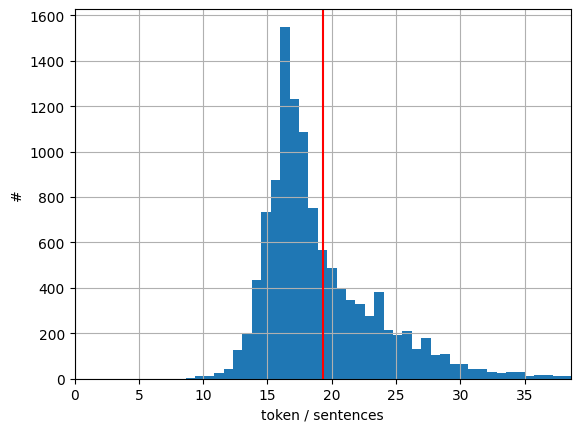

In [195]:
ratio = np.array(cnn_token_num_h)/np.array(cnn_sents_num_h)
mean = np.mean(ratio)
print(mean)
fig = plt.figure()
ax = fig.subplots()
ax.hist(ratio, bins=200)
ax.axvline(x=mean, color='red')
ax.set_xlim(0,2*mean)
ax.set_xlabel('token / sentences')
ax.set_ylabel('#')
plt.grid()
plt.show()

- mean of ${\color{red}\mathrm{Token}/\mathrm{Sentence}=19.279391011018365{\,\mathrm{[token/sents.]}}}$ (in highlights)
- $\displaystyle \mathrm{floor}\left(\frac{512 {\rm token}}{19.2794\,\mathrm{[token/sents.]}}\right) = 26$
- $\displaystyle \mathrm{floor}\left(\frac{256 {\rm token}}{19.2794\,\mathrm{[token/sents.]}}\right) = 13$

In [203]:
goal_num_sents = count_sents(df['highlights'][719])
bert_summarize_article_with_log(df['article'][719],
        max_bert_input_length=26, # sentences
        step_summary_length=13, # sentences
        final_summary_length=goal_num_sents, # sentences,
        log=True)


original layer-1 (4  parts):    |26 |26 |26 | 6 |
 summary layer-1 (4  parts):    |13 |13 |14 | 5 |
original layer-2 (2  parts):       |26 |19 |
 summary layer-2 (2  parts):       |13 |14 |
original layer-2  (1  parts):       |13 |
summary  layer-2  (1  parts):       | 3 |

'(CNN)James Holmes made his introduction to the world in a Colorado cinema filled with spectators watching a midnight showing of the new Batman movie, "The Dark Knight Rises," in June 2012. In January, he had a beard and eyeglasses. In March 2012, he told a classmate he wanted to kill people, and that he would do so "when his life was over," court documents said.'

# BERT summarize Process

In [213]:
task_name = 'highlighted'
# task_name = 'summarized'
# task_name = 'compressed'
# task_name = 'abstracted'

df_original = pd.read_csv("./dat/cnn_dailymail_test.csv") # 這是原始的dataset但不會用到它
df_by_llama = pd.read_csv(f"./dat/cnn_dailymail_test-{task_name}.csv")
df_original.shape, df_by_llama.shape

((11490, 3), (11490, 2))

In [219]:
SAVE_RESULT_PATH = f'./dat/cnn_dailymail_test-{task_name}-bert.csv'
artcle_id = df_by_llama['id']
llama_articles = df_by_llama['article']
cnn_hightlights = df_original['highlights']

max_num = len(cnn_id)
summarized_articles = []
for i in tqdm(range(max_num), total=max_num, desc='BERT summarize'):
    try:
        goal_num_sents = count_sents(cnn_hightlights[i])
        summarized_article = bert_summarize_article(llama_articles[i],
                                                    max_bert_input_length=26, # sentences
                                                    step_summary_length=13, # sentences
                                                    final_summary_length=goal_num_sents, # sentences
                                                   )
        summarized_articles.append(summarized_article)
    except Exception as e:
        print(f"Error processing row {i}: {e}")

df_bert = pd.DataFrame({
    'id': artcle_id,
    'article': summarized_articles
})
df_bert.to_csv(SAVE_RESULT_PATH, index=None)
print("summarize complete => save to csv complete")

BERT summarize:   0%|                                                                                            | 12/11490 [00:21<5:39:15,  1.77s/it]


KeyboardInterrupt: 

# BERT summarize testing

**Following is testing for article summairze by BERT and do ROUGE**

In [7]:
def calculate_rouge_scores(reference_text, generated_text):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_text, generated_text)
    rouge_1 = scores['rouge1'].fmeasure
    rouge_2 = scores['rouge2'].fmeasure
    rouge_L = scores['rougeL'].fmeasure
    return rouge_1, rouge_2, rouge_L